### Segment Audio file

##### Import library

In [29]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

##### Import audio file (data, sampling rate)

In [30]:
audio_path = "audio/MIDI-Unprocessed_SMF_02_R1_2004_01-05_ORIG_MID--AUDIO_02_R1_2004_05_Track05_wav.wav"
y, sr = librosa.load(audio_path, sr=None, res_type="kaiser_fast")

print("Sampling rate : ", sr)           
print("Sampling point : ", y.shape)      
print(f"Original Audio Duration: {len(y) / sr:.2f} sec")

Sampling rate :  44100
Sampling point :  (42760043,)
Original Audio Duration: 969.62 sec


##### CQT configuration & Segment configuration

In [31]:
# CQT configuration
hop_length_sec = 0.01               # 10 ms
fmin = librosa.note_to_hz('A0')     # Start at A0 (88 keys piano)
bin_per_octave = 36                 # Number of bins per octave
n_bins = 267                        # Number of frequency bins, starting at fmin
hop_length_samples = int(hop_length_sec * sr)       # Number of samples 

# Define segment size 
segment_duration = 10  # seconds
segment_samples = sr * segment_duration  # Convert seconds to samples

In [32]:
# Compute CQT Duration
#
# n_frames = CQT.shape[1]
# computed_duration = (n_frames * hop_length_samples) / sr  # Convert frames to seconds
# # Display information
# # print(f"Computed Spectrogram Duration: {computed_duration:.2f} sec")          # Only in whole song only

C:\Users\napat\AppData\Local\Temp\ipykernel_21372\323936281.py:19: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(CQT_db, sr=sr, x_axis='time', y_axis='cqt_note', hop_length=hop_length_samples)


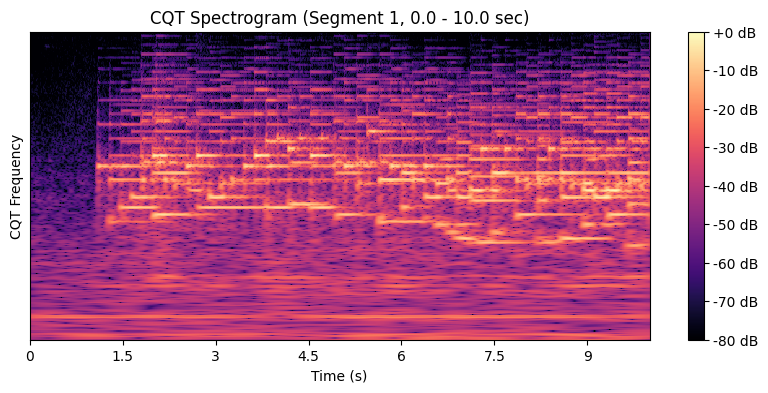

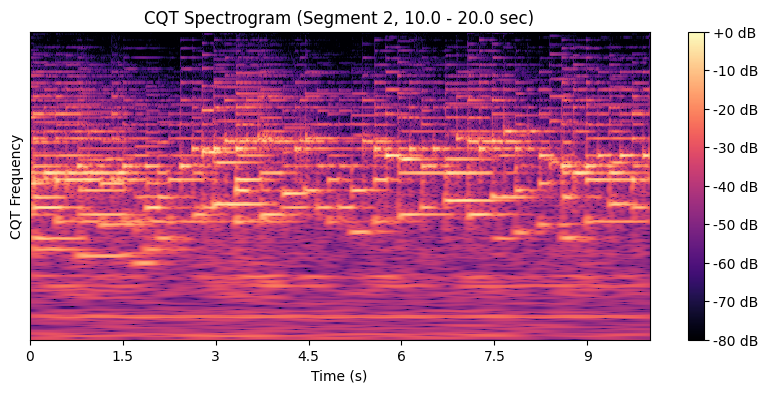

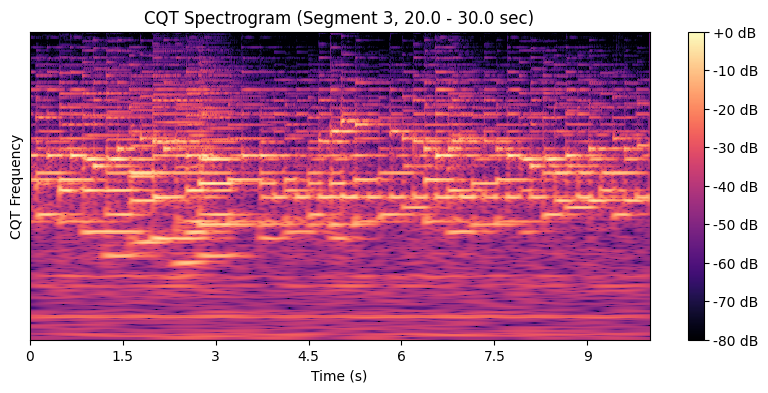

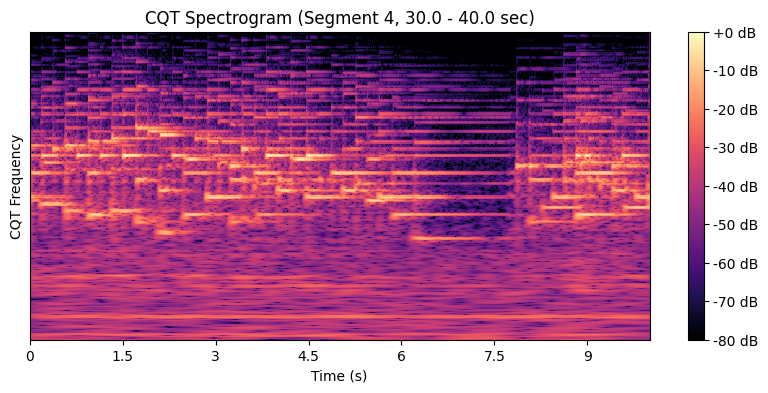

In [33]:
# Loop through the audio file in 10 second chunks (Plot only 3 graphs)
num_plot = 3

for i, start_sample in enumerate(range(0, len(y), segment_samples)):
    if i > num_plot:
        break
    end_sample = start_sample + segment_samples
    y_segment = y[start_sample:end_sample]  # Extract 10-sec segment

    # Compute CQT for this segment
    CQT_segment = librosa.cqt(y=y_segment, sr=sr, hop_length=hop_length_samples, 
                              bins_per_octave=bin_per_octave, n_bins=n_bins, fmin=fmin)

    # Convert to dB scale
    CQT_db = librosa.amplitude_to_db(np.abs(CQT_segment), ref=np.max)

    # Plot CQT for this segment
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(CQT_db, sr=sr, x_axis='time', y_axis='cqt_note', hop_length=hop_length_samples)
    plt.colorbar(format='%+2.0f dB')
    plt.title(f'CQT Spectrogram (Segment {i+1}, {start_sample / sr:.1f} - {end_sample / sr:.1f} sec)')
    plt.xlabel('Time (s)')
    plt.ylabel('CQT Frequency')
    plt.show()



### Segment for simple audio file

##### Import & output path

In [36]:
import os
audio_path = "audio/my_melody.wav"
y, sr = librosa.load(audio_path, sr=None, res_type="kaiser_fast")

output_folder = "CQT_segments_test"
os.makedirs(output_folder, exist_ok=True)

##### Config

In [37]:
# CQT configuration
hop_length_sec = 0.01               # 10 ms
fmin = librosa.note_to_hz('A0')     # Start at A0 (88 keys piano)
bin_per_octave = 36                 # Number of bins per octave
n_bins = 267                        # Number of frequency bins, starting at fmin
hop_length_samples = int(hop_length_sec * sr)       # Number of samples 

# Define segment size 
segment_duration = 10  # seconds
segment_samples = sr * segment_duration  # Convert seconds to samples

##### Chunking and save

In [ ]:
# Loop through the audio file in 10-second chunks
for i, start_sample in enumerate(range(0, len(y), segment_samples)):
    end_sample = start_sample + segment_samples
    y_segment = y[start_sample:end_sample]  # Extract 10-sec segment

    # Compute CQT for this segment
    CQT_segment = librosa.cqt(y=y_segment, sr=sr, hop_length=hop_length_samples, 
                              bins_per_octave=bin_per_octave, n_bins=n_bins, fmin=fmin)
    CQT_db = librosa.amplitude_to_db(np.abs(CQT_segment), ref=np.max)

    npy_filename = os.path.join(output_folder, f"CQT_segment_{i}.npy")
    np.save(npy_filename, CQT_db)
    print(f"Saved: {npy_filename}")

Saved: CQT_segments_test\CQT_segment_0.npy


##### Import .npy CQT spectrogram as X_train

In [38]:
import glob
X_train = []
for file in sorted(glob.glob("CQT_segments_test/CQT_segment_*.npy")):
    CQT_array = np.load(file)
    X_train.append(CQT_array)

In [39]:
# Convert List to array 
X_train = np.array(X_train)
print(f"Original Shape of X_train: {X_train.shape}") 

# Reshape to input size of CNN
X_train = X_train.reshape(-1, X_train.shape[1], X_train.shape[2], 1)  # (samples, n_bins, time_bins, channels)
print(f"Reshaped for CNN: {X_train.shape}") 


Original Shape of X_train: (1, 267, 401)
Reshaped for CNN: (1, 267, 401, 1)


C:\Users\napat\AppData\Local\Temp\ipykernel_21372\1659728064.py:7: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(CQT_sample, sr=sr, x_axis='time', y_axis='cqt_note', hop_length=hop_length_samples)


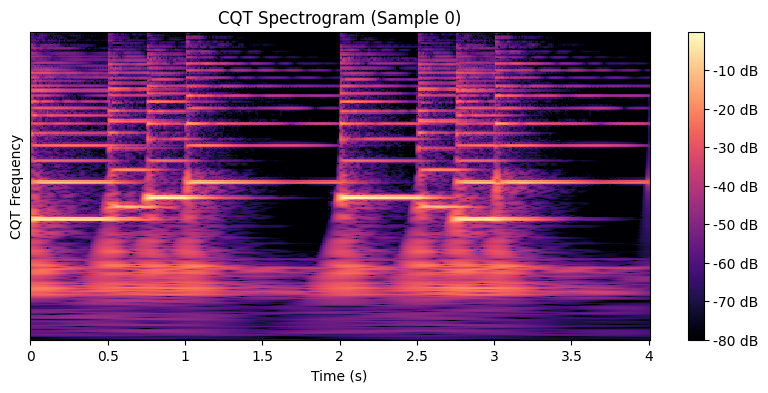

In [40]:
# Plot first CQT graph
sample_index = 0 
CQT_sample = X_train[sample_index, :, :, 0]  # Remove last dimension

# Plot CQT
plt.figure(figsize=(10, 4))
librosa.display.specshow(CQT_sample, sr=sr, x_axis='time', y_axis='cqt_note', hop_length=hop_length_samples)
plt.colorbar(format='%+2.0f dB')
plt.title(f'CQT Spectrogram (Sample {sample_index})')
plt.xlabel('Time (s)')
plt.ylabel('CQT Frequency')
plt.show()

### Load Midi file

##### Import 

In [ ]:
import pretty_midi
path = "midi/output.mid"         # Midi file path
midi_data = pretty_midi.PrettyMIDI(path)

midi_duration = midi_data.get_end_time()  # seconds
print(f"MIDI duration: {midi_duration} sec")   


MIDI duration: 1.0 sec


##### Extract midi file to segment

In [60]:
##### Extract Midi note into segment
import numpy as np
num_segments = int(np.ceil(midi_duration / segment_duration))

midi_segments = []

for i in range(num_segments):
    start_time = i * segment_duration
    end_time = (i + 1) * segment_duration

    # Extract MIDI notes in this time range for mapping with CQT segment
    notes_in_segment = []
    for instrument in midi_data.instruments:    # Extract instrument on midi
        for note in instrument.notes:           # note contain : Start time, End time, Pitch, Velocity
            if start_time <= note.start < end_time or start_time < note.start <= end_time:
                notes_in_segment.append((note.pitch, note.start - start_time, note.end - start_time, note.velocity))

    midi_segments.append(notes_in_segment)

print(f"Extracted {len(midi_segments)} MIDI segments")


Extracted 1 MIDI segments


In [61]:
for i in range(len(midi_segments)):
    print(f"Note in segment {i} :", len(midi_segments[i]))

Note in segment 0 : 6


In [62]:
midi_segments

[[(60, 0.0, 0.5, 100),
  (64, 0.0, 0.5, 100),
  (67, 0.0, 0.5, 100),
  (62, 0.5, 1.0, 100),
  (65, 0.5, 1.0, 100),
  (69, 0.5, 1.0, 100)]]

##### Midi to pianoroll(time series)

In [63]:
def midi_to_pianoroll(midi_notes, segment_length=10, fs=100):
    time_bins = segment_length * fs     # Number of time steps
    pitch_bins = 128                    # MIDI has 128 possible notes

    pianoroll = np.zeros((pitch_bins, time_bins))  

    for pitch, start, end, velo in midi_notes:
        start_bin = int(start * fs)
        end_bin = int(end * fs)
        pianoroll[pitch, start_bin:end_bin] = 1  # Mark active notes

    return pianoroll

# Convert all MIDI segments
pianoroll_labels = [midi_to_pianoroll(segment) for segment in midi_segments]

# Convert to NumPy array for CNN training
pianoroll_labels = np.array(pianoroll_labels)

print(f"Pianoroll shape: {pianoroll_labels.shape}")  # (num_segments, 128, time_bins[100 timestep/second])


Pianoroll shape: (1, 128, 1000)


In [ ]:
pianoroll_labels

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [65]:
temp = []
for i in range(len(pianoroll_labels[0])):
    for j in range(len(pianoroll_labels[0][i])):
        if pianoroll_labels[0][i][j] == 1 and [i,j] not in temp: 
            temp.append([i, j])

In [66]:
pianoroll_labels[0][60]         # C4 note

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [67]:
temp

[[60, 0],
 [60, 1],
 [60, 2],
 [60, 3],
 [60, 4],
 [60, 5],
 [60, 6],
 [60, 7],
 [60, 8],
 [60, 9],
 [60, 10],
 [60, 11],
 [60, 12],
 [60, 13],
 [60, 14],
 [60, 15],
 [60, 16],
 [60, 17],
 [60, 18],
 [60, 19],
 [60, 20],
 [60, 21],
 [60, 22],
 [60, 23],
 [60, 24],
 [60, 25],
 [60, 26],
 [60, 27],
 [60, 28],
 [60, 29],
 [60, 30],
 [60, 31],
 [60, 32],
 [60, 33],
 [60, 34],
 [60, 35],
 [60, 36],
 [60, 37],
 [60, 38],
 [60, 39],
 [60, 40],
 [60, 41],
 [60, 42],
 [60, 43],
 [60, 44],
 [60, 45],
 [60, 46],
 [60, 47],
 [60, 48],
 [60, 49],
 [62, 50],
 [62, 51],
 [62, 52],
 [62, 53],
 [62, 54],
 [62, 55],
 [62, 56],
 [62, 57],
 [62, 58],
 [62, 59],
 [62, 60],
 [62, 61],
 [62, 62],
 [62, 63],
 [62, 64],
 [62, 65],
 [62, 66],
 [62, 67],
 [62, 68],
 [62, 69],
 [62, 70],
 [62, 71],
 [62, 72],
 [62, 73],
 [62, 74],
 [62, 75],
 [62, 76],
 [62, 77],
 [62, 78],
 [62, 79],
 [62, 80],
 [62, 81],
 [62, 82],
 [62, 83],
 [62, 84],
 [62, 85],
 [62, 86],
 [62, 87],
 [62, 88],
 [62, 89],
 [62, 90],
 [62, 91]

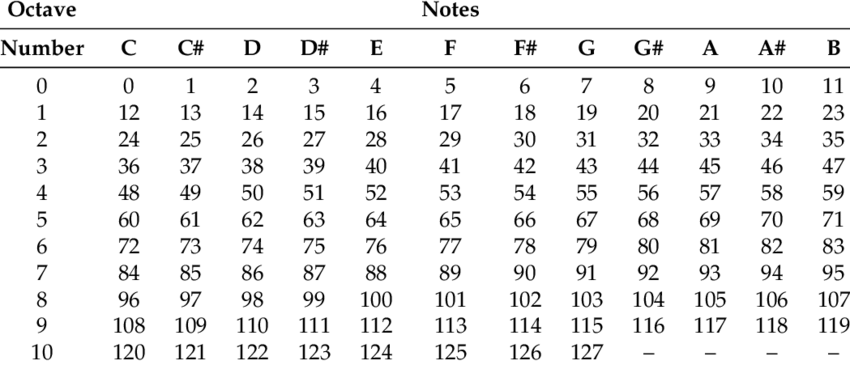